In [1]:
import time
import numpy as np
import gym
env = gym.make('CartPole-v0')

In [2]:
# 看一下动作空间
print(env.action_space)

Discrete(2)


In [3]:
# 看一下状态空间，以及它的取值大小
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [4]:
env.reset()
# 第1项表示小车的位置，它的取值范围为[-4.8, 4.8]；
# 第2项表示小车速度，取值没有限制；
# 第3项为杆偏离垂直线的角度，取值范围为[-24 degree, 24 degree]；
# 第4项为杆顶端的速度，取值没有限制。

array([0.00951964, 0.00424478, 0.04580445, 0.02378354])

## 1. 无策略随机控制小车 

In [5]:
for _ in range(200):
    env.render()
    s, r, done, info = env.step( env.action_space.sample() )
    print( s, r )
    if done:
        break
    time.sleep( 0.1 )

[ 0.00960453  0.19868094  0.04628012 -0.254103  ] 1.0
[0.01357815 0.00292979 0.04119806 0.05281084] 1.0
[ 0.01363675 -0.19275794  0.04225428  0.35820216] 1.0
[ 0.00978159 -0.38845432  0.04941832  0.66390378] 1.0
[ 0.0020125  -0.58422765  0.0626964   0.97172834] 1.0
[-0.00967205 -0.78013241  0.08213097  1.28342879] 1.0
[-0.0252747  -0.58614674  0.10779954  1.0175505 ] 1.0
[-0.03699763 -0.78252773  0.12815055  1.34204378] 1.0
[-0.05264819 -0.97900811  0.15499143  1.67192086] 1.0
[-0.07222835 -0.78598911  0.18842984  1.43124824] 1.0
[-0.08794813 -0.59362552  0.21705481  1.20288136] 1.0


In [6]:
env.close()

## 2. DQN控制

In [7]:
import collections
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, losses

N_of_D = 2000 # 经验回放池D的大小
size_batch = 32 # 每批训练的样本数
n_states = 4 # 状态空间的大小
n_actions = 2 # 动作空间的大小
Q_net_structure = [128, 128, n_actions] # Q网络的结构，列表中分别为各隐层的节点个数
epsilon_decay = 0.995 # ε贪心策略中ε的衰减率
epsilon_min = 0.01 # ε贪心策略中ε的最小值

episode_score_list = [] # 用来记录每次尝试的得分

In [8]:
# 经验回放池D
class ReplayMemory():

    def __init__(self, N=2000, size_batch=32):
        # 双向队列
        self.N = N
        self.size_batch = size_batch
        self.memory = collections.deque(maxlen=self.N) # 采用双向队列作为存储结构
    
    def size(self):
        return len(self.memory)
    
    def push(self, transition):
        self.memory.append(transition)

    def sample(self): # 从D中采样size_batch大小的样本集
        transitions = random.sample(self.memory, self.size_batch)
        s_list, a_list, r_list, next_s_list, done_list = [], [], [], [], []
        # 按类别进行整理
        for transition in transitions:
            s, a, r, next_s, done = transition
            s_list.append(s)
            a_list.append([a])
            r_list.append([r])
            next_s_list.append(next_s)
            done_list.append([done])
        return s_list, a_list, r_list, next_s_list, done_list

In [9]:
# 采用第三种结构的神经网络
class Q_net(keras.Model):
    def __init__(self, Q_net_structure=[128, 128, 2]):
        # 创建Q网络
        super(Q_net, self).__init__()
        self.Q_net_structure = Q_net_structure
        self.fc = []
        self.n_actions = Q_net_structure[-1]
        for i in range(len(self.Q_net_structure)):
            self.fc.append( layers.Dense(self.Q_net_structure[i]) )
    
    # 重写父类函数，实现前向输出        
    def call(self, x, training=None):
        for i in range(len(self.Q_net_structure)-1):
            x = tf.nn.relu(self.fc[i](x))
        x = self.fc[ len(self.Q_net_structure)-1 ](x)
        return x
    
    # 基于ε-gredy贪心策略，根据当前状态s的所有动作值函数，采样输出动作值
    def epsilon_greedy_sample(self, s, epsilon):
        rand = random.random()
        if rand < epsilon: # 探索
            return random.randint(0, self.n_actions-1)
        else:  # 利用，将s经过网络前向预测，得到输出
            s = tf.constant(s, dtype=tf.float32) # 转换成Tensor
            s = tf.expand_dims(s, axis=0)
            out = self(s)[0] # 前向预测
            return int(tf.argmax(out))

In [10]:
# 更新ε贪心策略中的ε
def update_epsilon( epsilon, epsilon_decay=0.995, epsilon_min=0.01 ):
    if epsilon >= epsilon_min:
        epsilon *= epsilon_decay
    return epsilon

In [11]:
def DQN(env, M=2000, learning_rate=0.0002, epsilon=1.0, gamma=0.99):
    # M = 2000 # 尝试次数
    # learning_rate = 0.0002 # 优化器步长
    # epsilon=1.0 # ε贪心策略中的ε
    # gamma = 0.99 # 折扣系数
    
    D = ReplayMemory( N=N_of_D, size_batch=size_batch )  # 经验回放池
        
    q = Q_net()  # 预测网络，Q网络
    q.build(input_shape=(2, 4))
    q_ = Q_net()  # 目标网络
    q_.build(input_shape=(2, 4))
    
    for sv, dv in zip(q.variables, q_.variables):
        dv.assign(sv) # 将目标网络系数设置为预测网络系数

    C = 10 # C次采样后，更新目标网络为预测网络
    score = 0.0
    optimizer = optimizers.Adam(lr=learning_rate)

    for i in range(M):  # 训练次数
        # 逐步减小ε
        epsilon = update_epsilon( epsilon, epsilon_decay, epsilon_min )
        
        s = env.reset()
        episode_score = 0.0
        for t in range(600):  # 开始尝试，每次尝试最多走600步
            a = q.epsilon_greedy_sample(s, epsilon)
            next_s, r, done, _ = env.step(a)
            D.push((s, a, r, next_s, done)) # 样本存入经验回放池
            s = next_s  # 更新状态
            episode_score += r 
            if done:  # 尝试结束
                score += episode_score # 记录最近C次的总回报
                episode_score_list.append(episode_score)
                episode_score = 0.0
                break

            if D.size() > 500:  # 开始更新Q网络
                
                huber = losses.Huber()
                
                # 从经验回放池中随机提取一批训练样本,并转换成Tensor
                s_list, a_list, r_list, next_s_list, done_list = D.sample()
                s_ = tf.constant(s_list, dtype=tf.float32)
                a_ = tf.constant(a_list, dtype=tf.int32)
                r_ = tf.constant(r_list, dtype=tf.float32)
                next_s_ = tf.constant(next_s_list, dtype=tf.float32)
                done_ = tf.constant(done_list, dtype=tf.float32)
                
                with tf.GradientTape() as tape:
                    
                    q_predict = q(s_)  # 得到预测值Q(s_,*)
                    
                    # 因为是第三种形式的网络，所以要从Q(s_,*)取对应动作的输出Q值
                    indices = tf.expand_dims(tf.range(a_.shape[0]), axis=1) # reshape
                    indices = tf.concat([indices, a_], axis=1) # 对应的动作
                    q_a = tf.gather_nd(q_predict, indices) # 对应动作的Q预测值
                    q_a = tf.expand_dims(q_a, axis=1) # reshape
                    
                    # 从目标网络求下一状态s'的最大Q值，并计算样本的标签值
                    max_next_q = tf.reduce_max(q_(next_s_),axis=1,keepdims=True)
                    labels = r_ + gamma * max_next_q * (1-done_) # done_等1，说明是最终状态
                    
                    # 计算预测值与标签值的误差
                    loss = huber(q_a, labels) 
                
                # 计算梯度，并优化网络
                grads = tape.gradient(loss, q.trainable_variables)
                optimizer.apply_gradients(zip(grads, q.trainable_variables))

        # C次采样后，更新目标网络为预测网络，并输出中间信息
        if (i+1) % C == 0:
            for sv, dv in zip(q.variables, q_.variables):
                dv.assign(sv) # 将目标网络系数设置为预测网络系数
            print("尝试次数:{}, 最近{}次平均得分:{:.1f}, 经验回放池大小:{}, ε:{:.3f}" \
                  .format(i+1, C, score / C, D.size(), epsilon ))
            score = 0.0

In [12]:
DQN(env, M=2000, learning_rate=0.0002, epsilon=1.0, gamma=0.99)

尝试次数:10, 最近10次平均得分:19.7, 经验回放池大小:197, ε:0.951
尝试次数:20, 最近10次平均得分:21.8, 经验回放池大小:415, ε:0.905
尝试次数:30, 最近10次平均得分:23.6, 经验回放池大小:651, ε:0.860
尝试次数:40, 最近10次平均得分:14.3, 经验回放池大小:794, ε:0.818
尝试次数:50, 最近10次平均得分:15.4, 经验回放池大小:948, ε:0.778
尝试次数:60, 最近10次平均得分:14.1, 经验回放池大小:1089, ε:0.740
尝试次数:70, 最近10次平均得分:18.2, 经验回放池大小:1271, ε:0.704
尝试次数:80, 最近10次平均得分:14.5, 经验回放池大小:1416, ε:0.670
尝试次数:90, 最近10次平均得分:14.2, 经验回放池大小:1558, ε:0.637
尝试次数:100, 最近10次平均得分:15.5, 经验回放池大小:1713, ε:0.606
尝试次数:110, 最近10次平均得分:18.3, 经验回放池大小:1896, ε:0.576
尝试次数:120, 最近10次平均得分:13.4, 经验回放池大小:2000, ε:0.548
尝试次数:130, 最近10次平均得分:12.5, 经验回放池大小:2000, ε:0.521
尝试次数:140, 最近10次平均得分:12.5, 经验回放池大小:2000, ε:0.496
尝试次数:150, 最近10次平均得分:12.9, 经验回放池大小:2000, ε:0.471
尝试次数:160, 最近10次平均得分:13.2, 经验回放池大小:2000, ε:0.448
尝试次数:170, 最近10次平均得分:12.1, 经验回放池大小:2000, ε:0.427
尝试次数:180, 最近10次平均得分:12.9, 经验回放池大小:2000, ε:0.406
尝试次数:190, 最近10次平均得分:13.2, 经验回放池大小:2000, ε:0.386
尝试次数:200, 最近10次平均得分:13.9, 经验回放池大小:2000, ε:0.367
尝试次数:210, 最近10次平均得分:19.2, 经验回放池大小:2000, ε:0.349
尝试次数:2

尝试次数:1700, 最近10次平均得分:133.0, 经验回放池大小:2000, ε:0.010
尝试次数:1710, 最近10次平均得分:143.5, 经验回放池大小:2000, ε:0.010
尝试次数:1720, 最近10次平均得分:160.0, 经验回放池大小:2000, ε:0.010
尝试次数:1730, 最近10次平均得分:169.8, 经验回放池大小:2000, ε:0.010
尝试次数:1740, 最近10次平均得分:173.5, 经验回放池大小:2000, ε:0.010
尝试次数:1750, 最近10次平均得分:191.2, 经验回放池大小:2000, ε:0.010
尝试次数:1760, 最近10次平均得分:197.2, 经验回放池大小:2000, ε:0.010
尝试次数:1770, 最近10次平均得分:197.4, 经验回放池大小:2000, ε:0.010
尝试次数:1780, 最近10次平均得分:190.2, 经验回放池大小:2000, ε:0.010
尝试次数:1790, 最近10次平均得分:138.7, 经验回放池大小:2000, ε:0.010
尝试次数:1800, 最近10次平均得分:118.6, 经验回放池大小:2000, ε:0.010
尝试次数:1810, 最近10次平均得分:110.2, 经验回放池大小:2000, ε:0.010
尝试次数:1820, 最近10次平均得分:85.9, 经验回放池大小:2000, ε:0.010
尝试次数:1830, 最近10次平均得分:95.6, 经验回放池大小:2000, ε:0.010
尝试次数:1840, 最近10次平均得分:98.4, 经验回放池大小:2000, ε:0.010
尝试次数:1850, 最近10次平均得分:100.2, 经验回放池大小:2000, ε:0.010
尝试次数:1860, 最近10次平均得分:105.7, 经验回放池大小:2000, ε:0.010
尝试次数:1870, 最近10次平均得分:116.3, 经验回放池大小:2000, ε:0.010
尝试次数:1880, 最近10次平均得分:120.6, 经验回放池大小:2000, ε:0.010
尝试次数:1890, 最近10次平均得分:121.8, 经验回放池大小:2000, ε:0.010
尝试次

In [13]:
# 把每次尝试的得分都画出来
import matplotlib.pyplot as plt
def plot_score(episode_score_list):
    plt.plot(episode_score_list)
    x = np.array(range(len(episode_score_list)))
    smooth_func = np.poly1d(np.polyfit(x, episode_score_list, 3))
    plt.plot(x, smooth_func(x), label='Mean', linestyle='--')
    plt.show()

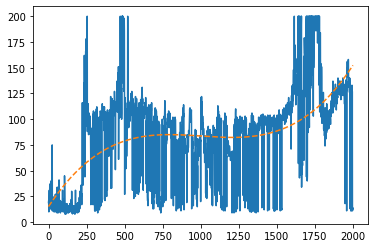

In [14]:
plot_score(episode_score_list)

## 3.策略参数化示例

### 3.1 用随机的连接系数和阈值的神经元来参数化策略 

In [15]:
# 神经元模型
def neuron(s, paras):
    value = np.dot( paras[:4], s ) + paras[4] 
    if value >= 0:
        return 1
    else:
        return 0

In [16]:
score = 0
paras = np.random.rand(5)  # 随机产生神经元的连接系数和阈值

s = env.reset()
print(s)
for t in range(200):
    env.render()
    a = neuron(s, paras)
    s, r, done, info = env.step(a)
    if done:
        break
    print(s, r)
    score += r  
    time.sleep(0.1)
print('Paras：', paras)
print('Scores：', score)

[-0.04071514 -0.0440691   0.00341687  0.01008208]
[-0.04159653  0.15100369  0.00361851 -0.28152083] 1.0
[-0.03857645  0.34607384 -0.00201191 -0.5730603 ] 1.0
[-0.03165497  0.54122394 -0.01347312 -0.86637637] 1.0
[-0.0208305   0.34628791 -0.03080064 -0.57795984] 1.0
[-0.01390474  0.5418277  -0.04235984 -0.88018437] 1.0
[-0.00306818  0.34730605 -0.05996353 -0.60111369] 1.0
[ 0.00387794  0.5432133  -0.0719858  -0.91206513] 1.0
[ 0.0147422   0.34913525 -0.0902271  -0.64284757] 1.0
[ 0.02172491  0.54539127 -0.10308405 -0.96252491] 1.0
[ 0.03263273  0.35179423 -0.12233455 -0.70392397] 1.0
[ 0.03966862  0.54837999 -0.13641303 -1.03247555] 1.0
[ 0.05063622  0.35531005 -0.15706254 -0.78554218] 1.0
[ 0.05774242  0.16265447 -0.17277339 -0.54610268] 1.0
[ 0.06099551  0.35972903 -0.18369544 -0.88785641] 1.0
[ 0.06819009  0.16751148 -0.20145257 -0.65808431] 1.0
Paras： [0.44742868 0.44087866 0.49587335 0.97434063 0.59507856]
Scores： 15.0


### 3.2 爬山法优化神经元的连接系数和阈值

In [17]:
# 测试不同连接系数和阈值的神经元的持续步长
def rewards_by_paras(env, paras):
    s = env.reset()
    r = 0
    rewards = 0
    for t in range(1000):
        a = neuron(s, paras)
        s, r, done, info = env.step(a)
        rewards += r
        # print(sum_reward, action, observation, reward, done, info)
        if done: # 本次仿真结束
            break
    return rewards

In [18]:
delta = 0.01 # 爬山法中试探的步长
top_rewards = 0
top_paras = None
for _ in range(100): # 多次爬山，选取最好的结果
    score = 0
    paras = np.random.rand(5)  # 随机产生神经元的连接系数和阈值
    most_rewards = rewards_by_paras(env, paras)
    
    for i in range(200):

        best_paras = paras
        cur_rewards = most_rewards

        rewards = rewards_by_paras(env, paras + [ delta, 0, 0, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ delta, 0, 0, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ -delta, 0, 0, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ -delta, 0, 0, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, delta, 0, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, delta, 0, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, -delta, 0, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, -delta, 0, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, delta, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, delta, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, -delta, 0, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, -delta, 0, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, 0, delta, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, 0, delta, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, 0, -delta, 0 ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, 0, -delta, 0 ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, 0, 0, delta ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, 0, 0, delta ]

        rewards = rewards_by_paras(env, paras + [ 0, 0, 0, 0, -delta ])
        if rewards > most_rewards:
            most_rewards = rewards
            best_paras = paras + [ 0, 0, 0, 0, -delta ]

        if (cur_rewards == most_rewards) or (most_rewards >= 200): # 到了山顶，或者已经达到要求
            break
        else:
            paras = best_paras
            
    #print(most_rewards, paras)
    if most_rewards > top_rewards:
        top_rewards = most_rewards
        top_paras = paras

print(top_rewards, top_paras)

200.0 [0.50315706 0.87398643 0.91771455 0.92151229 0.0033427 ]


In [19]:
# 用优化后的神经元作为策略
paras = top_paras # 用爬山法得到的连接系数和阈值
ave_score = []
for _ in range(10):
    score = 0.0
    s = env.reset()
    for t in range(200):
        env.render()
        a = neuron(s, paras) # 用优化后的神经元来给出下一步动作
        s, r, done, info = env.step(a)
        score += r  
        if done:
            break
    print('Score：', score)
    ave_score.append(score)
print('平均score：', np.mean(ave_score))

Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
Score： 200.0
平均score： 200.0


### 3.3 用神经网络来参数化策略 

### MindSpore版本

In [20]:
# 神经网络模型
import mindspore.dataset as ds
import numpy as np
from mindspore.common.initializer import Normal
from mindspore import nn, Parameter
from mindspore import Model
from mindspore.nn import MSE

batch_size = 5 # 每批训练样本数（批梯度下降法）
repeat_size = 1 # 样本重复次数

class ms_Net(nn.Cell):
    def __init__(self):
        super(ms_Net, self).__init__()
        self.fc1 = nn.Dense(4, 10, Normal(0.02), Normal(0.02), True)
        self.fc2 = nn.Dense(10, 1, Normal(0.02), Normal(0.02), True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def construct(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

net = ms_Net() # 实例化

net_loss = nn.loss.MSELoss() # 定义损失函数
opt = nn.Adam(params=net.trainable_params()) # 定义优化方法
ms_model = Model(net, net_loss, opt) # 将网络结构、损失函数和优化方法进行关联

In [21]:
# 从随机产生的轨迹中选取较好的作为神经网络的训练样本
X, y = [], []
sum_episodes = 0
for _ in range(10000):
    s = env.reset()
    score = 0.0
    xx, yy = [], []
    for t in range(300):
        a = env.action_space.sample() # 随机产生一个动作
        s = s.astype(np.float32)
        xx.append(s)
        yy.append(a)
        s, r, done, _ = env.step(a)
        score += r
        if done:
            break
    if score > 80: # 得分大于80的轨迹才能采用
        X += xx
        y += yy
        sum_episodes += 1
        
print("共采用", sum_episodes, "条轨迹作为训练样本")

共采用 28 条轨迹作为训练样本


In [22]:
np.random.seed(1026)

class DatasetGenerator:
    def __init__(self, X, y):
        self.data = X
        self.label = y

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

dataset_generator = DatasetGenerator(X, np.array(y).reshape(-1,1))
ds_train = ds.GeneratorDataset(dataset_generator, ["data", "label"], shuffle=False)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.repeat(repeat_size)

#for i, data in enumerate(ds_train.create_dict_iterator()):
#    print("第 %d 批样本"%i)
#    print('{}'.format(data["data"]), '{}'.format(data["label"]))

In [25]:
ms_epoch = 10
ms_model.train(ms_epoch, ds_train, dataset_sink_mode=False)

#for param in net.trainable_params():
#    print(param, param.asnumpy())

In [26]:
# 测试10次
import mindspore
from mindspore import Tensor

ave_score = []
for i in range(10):
    s = env.reset()
    score = 0
    while True:
        #env.render()
        s_T = Tensor([s], mindspore.float32)
        if ms_model.predict(s_T).asnumpy() > 0.5: # 用优化后的神经网络来给出下一步动作
            a = 1
        else:
            a = 0
        s, r, done, _ = env.step(a)  
        score += r    
        if done:       
            print('Score: ', score) 
            break
    ave_score.append(score)
print('平均score：', np.mean(ave_score))

Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
平均score： 200.0


### TensorFlow2版本 

In [27]:
# 神经网络模型
model = tf.keras.models.Sequential([
    layers.Dense(10, input_dim=env.observation_space.shape[0], activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()  # 打印神经网络信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X), np.array(y), epochs=10)

Train on 2515 samples
Epoch 1/10
2515/2515 [==============================] - 1s 450us/sample - loss: 0.2485
Epoch 2/10
2515/2515 [==============================] - 0s 62us/sample - loss: 0.2423
Epoch 3/10
2515/2515 [==============================] - 0s 65us/sample - loss: 0.2392
Epoch 4/10
2515/2515 [==============================] - 0s 60us/sample - loss: 0.2373
Epoch 5/10
2515/2515 [==============================] - 0s 60us/sample - loss: 0.2360
Epoch 6/10
2515/2515 [==============================] - 0s 60us/sample - loss: 0.2350
Epoch 7/10
2515/2515 [==============================] - 0s 72us/sample - loss: 0.2343
Epoch 8/10
2515/2515 [==============================] - 0s 69us/sample - loss: 0.2336
Epoch 9/10
2515/2515 [==============================] - 0s 120us/sample - loss: 0.2332
Epoch 10/10
2515/2515 [==============================] - 0s 60us/sample - loss: 0.2327


In [29]:
# 测试10次
ave_score = []
for i in range(10):
    s = env.reset()
    score = 0
    while True:
        #env.render()
        if model.predict(np.array([s]))[0][0] > 0.5: # 用优化后的神经网络来给出下一步动作
            a = 1
        else:
            a = 0
        s, r, done, _ = env.step(a)  
        score += r    
        if done:       
            print('Score: ', score) 
            break
    ave_score.append(score)
print('平均score：', np.mean(ave_score))

Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
平均score： 200.0


## 4.策略梯度法

In [30]:
# 计算一条轨迹的累积折扣回报序列
def G_seq( r_seq, gamma=0.95):
    next_G = 0
    Gs = []
    for i in reversed(range(len(r_seq))):
        G = r_seq[i] + gamma * next_G 
        Gs.append( G )
        next_G = G
    Gs.reverse()
    return Gs

In [31]:
# Softmax网络
model_softmax = keras.models.Sequential([
    layers.Dense(10, input_dim=env.observation_space.shape[0], activation='relu'),
    layers.Dense(env.action_space.n, activation="softmax")
])
model_softmax.compile(loss='mean_squared_error', optimizer=optimizers.Adam(0.001))

n_episodes = 1000  
episode_score_list = []
for i in range(n_episodes):
    s = env.reset()
    score = 0 # 记每次得分
    tau = []
    while True:
        pi_s = model_softmax.predict( np.array([s]) )[0] # 状态s的策略
        a = np.random.choice( len(pi_s), p=pi_s ) # 按概率大小随机确定要执行的动作
        next_s, r, done, _ = env.step( a )
        tau.append( [s, a, r] )

        score += r
        s = next_s
        if done:
            break
    
    X = [ step[0] for step in tau ]
    y = [ [1 if step[1] == i else 0 for i in range(env.action_space.n)] for step in tau ]
    G = G_seq( [step[2] for step in tau] )
    model_softmax.fit(np.array(X), np.array(y), sample_weight=np.array(G), epochs=10, verbose=0)

    episode_score_list.append(score)
    print('尝试次数:', i+1, ' ,得分:', score)
    
    # 10次尝试后，输出中间信息
    if (i+1) % 10 == 0:
        print("\n--最近{}次平均得分:{:.1f}\n".format(10, np.mean(episode_score_list[-10:]) ) )

    # 最近10次的平均分大于180时，不再训练
    if np.mean(episode_score_list[-10:]) > 180:
        print("\n\n***最近10次的平均分大于180，完成！！！***")
        break

尝试次数: 1  ,得分: 45.0
尝试次数: 2  ,得分: 11.0
尝试次数: 3  ,得分: 13.0
尝试次数: 4  ,得分: 15.0
尝试次数: 5  ,得分: 17.0
尝试次数: 6  ,得分: 25.0
尝试次数: 7  ,得分: 46.0
尝试次数: 8  ,得分: 13.0
尝试次数: 9  ,得分: 13.0
尝试次数: 10  ,得分: 16.0

--最近10次平均得分:21.4

尝试次数: 11  ,得分: 23.0
尝试次数: 12  ,得分: 14.0
尝试次数: 13  ,得分: 29.0
尝试次数: 14  ,得分: 23.0
尝试次数: 15  ,得分: 18.0
尝试次数: 16  ,得分: 15.0
尝试次数: 17  ,得分: 17.0
尝试次数: 18  ,得分: 35.0
尝试次数: 19  ,得分: 21.0
尝试次数: 20  ,得分: 20.0

--最近10次平均得分:21.5

尝试次数: 21  ,得分: 32.0
尝试次数: 22  ,得分: 48.0
尝试次数: 23  ,得分: 15.0
尝试次数: 24  ,得分: 75.0
尝试次数: 25  ,得分: 11.0
尝试次数: 26  ,得分: 19.0
尝试次数: 27  ,得分: 35.0
尝试次数: 28  ,得分: 71.0
尝试次数: 29  ,得分: 26.0
尝试次数: 30  ,得分: 17.0

--最近10次平均得分:34.9

尝试次数: 31  ,得分: 34.0
尝试次数: 32  ,得分: 130.0
尝试次数: 33  ,得分: 25.0
尝试次数: 34  ,得分: 16.0
尝试次数: 35  ,得分: 47.0
尝试次数: 36  ,得分: 46.0
尝试次数: 37  ,得分: 41.0
尝试次数: 38  ,得分: 99.0
尝试次数: 39  ,得分: 64.0
尝试次数: 40  ,得分: 49.0

--最近10次平均得分:55.1

尝试次数: 41  ,得分: 37.0
尝试次数: 42  ,得分: 46.0
尝试次数: 43  ,得分: 16.0
尝试次数: 44  ,得分: 46.0
尝试次数: 45  ,得分: 40.0
尝试次数: 46  ,得分: 47.0
尝试次数: 47  ,得

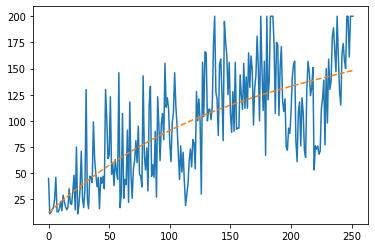

In [32]:
plot_score(episode_score_list)